## **Random Forest dan Logistic Regression**

# **IMPORT LIBRARY**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectPercentile
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pickle

# **Data Loading**

# *membaca data dari file eksternal & menampilkan contoh isi data*

In [2]:
df_gempa = pd.read_csv('earthquake_dataset.csv',header=0)

df_gempa.head()

,magnitude,depth,cdi,mmi,sig,alert
0,7.0,14.0,8.0,7.0,0.0,green
1,6.9,25.0,4.0,4.0,-33.0,green
2,7.0,579.0,3.0,3.0,-13.0,green
3,7.3,37.0,5.0,5.0,65.0,green
4,6.6,624.0,0.0,2.0,-98.0,green


# *menampilkan informasi mengenai masing-masing kolom (info) & menampilkan deskripsi terkait gambaran isi data (describe)*

In [3]:
print("Jumlah baris, kolom:", df_gempa.shape)    
print("\nTipe data:")
print(df_gempa.dtypes)

df_gempa.describe()

Jumlah baris, kolom: (1300, 6)

Tipe data:
magnitude    float64
depth        float64
cdi          float64
mmi          float64
sig          float64
alert         object
dtype: object


,magnitude,depth,cdi,mmi,sig
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000
mean,7.061008,50.321538,6.976154,6.939231,-9.749231
std,0.423738,104.348286,2.244875,1.354774,62.245214
min,6.500000,2.000000,0.000000,1.000000,-128.000000
25%,6.700000,12.000000,6.000000,6.000000,-54.000000
50%,7.000000,19.000000,8.000000,7.000000,-7.000000
75%,7.300000,38.000000,8.000000,8.000000,31.000000
max,8.600000,670.000000,9.000000,9.000000,127.000000


# **Data checking meliputi proses pengecekan apakah ada data yang:**

# *null & NaN*

In [4]:
print("Jumlah nilai kosong per kolom:\n", df_gempa.isnull().sum())

Jumlah nilai kosong per kolom:
 magnitude    0
depth        0
cdi          0
mmi          0
sig          0
alert        0
dtype: int64


# *duplikat*

In [5]:
print("Jumlah data duplikat:", df_gempa.duplicated().sum())

Jumlah data duplikat: 44


# *kosong*

In [6]:
for c in df_gempa.select_dtypes(include=['object']).columns:
    n_empty = (df_gempa[c].astype(str).str.strip() == '').sum()
    print(f"data kosong di {c}: {n_empty}")

data kosong di alert: 0


# *outlier*

In [7]:
# Quick outlier checks using IQR for numeric columns
num_cols = df_gempa.select_dtypes(include=[np.number]).columns.tolist()
print('\nKolom Numerik:', num_cols)

outlier_summary = {}
for col in num_cols:
    Q1 = df_gempa[col].quantile(0.25)
    Q3 = df_gempa[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df_gempa[(df_gempa[col] < lower) | (df_gempa[col] > upper)].shape[0]
    outlier_summary[col] = outliers
print('\nTotal Outlier per kolom yang numerik:')
print(outlier_summary)


Kolom Numerik: ['magnitude', 'depth', 'cdi', 'mmi', 'sig']

Total Outlier per kolom yang numerik:
{'magnitude': 13, 'depth': 168, 'cdi': 88, 'mmi': 5, 'sig': 0}


# **Data Preparation**

# *penanganan data yang null dan NaN*
    Karena tidak ada yang Null, maka tahap ini dilewati

# *penanganan data yang kosong*
    Karena tidak ada yang kosong, maka tahap ini dilewati

# *penanganan data yang duplikat*

In [8]:
# Remove duplicate rows
df_gempa2 = df_gempa.copy()
df_gempa2 = df_gempa2.drop_duplicates()

print("Jumlah data duplikat:", df_gempa2.duplicated().sum())

Jumlah data duplikat: 0


# *penanganan data yang outlier*

In [9]:
FEATURES = ['magnitude', 'depth', 'cdi', 'mmi', 'sig']
TARGET = 'alert'

for c in FEATURES:
    low = df_gempa2[c].quantile(0.01)
    high = df_gempa2[c].quantile(0.99)
    df_gempa2[c] = df_gempa2[c].clip(lower=low, upper=high)

# **Mengubah Alert(Object) Menjadi Numerik / Data Encoding**

In [10]:
label_mapping = {
    'green': 0,
    'yellow': 1,
    'orange': 2,
    'red': 3
}
df_gempa2['alert'] = df_gempa2['alert'].map(label_mapping)
print('\nLabel mapping:', label_mapping)


Label mapping: {'green': 0, 'yellow': 1, 'orange': 2, 'red': 3}


# **Pembagian Data Train Train/TestSplit**
FEATURES = ['magnitude', 'depth', 'cdi', 'mmi', 'sig']

TARGET = 'alert'

In [11]:
X = df_gempa2[FEATURES]
y = df_gempa2[TARGET]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=86, stratify=y
)


print('\nDistribusi Pembagian Train class:')
print(y_train.value_counts(normalize=True))
print('\nDistribusi Pembagian Test class:')
print(y_test.value_counts(normalize=True))

print("\nUkuran X_train, X_test:", X_train.shape, X_test.shape)


Distribusi Pembagian Train class:
alert
0    0.255973
1    0.253697
2    0.251422
3    0.238908
Name: proportion, dtype: float64

Distribusi Pembagian Test class:
alert
0    0.257294
1    0.251989
2    0.251989
3    0.238727
Name: proportion, dtype: float64

Ukuran X_train, X_test: (879, 5) (377, 5)


# **Feature selection**

In [12]:
# Untuk memilih nilai k dan persentil berdasarkan jumlah fitur
n_features = len(FEATURES)
k_options = list(range(1, n_features + 1)) # [1..n_features]
percentile_options = [10, 25, 50, 75, 100]


print('\nFeature selection param choices:')
print('k_options =', k_options)
print('percentile_options =', percentile_options)


Feature selection param choices:
k_options = [1, 2, 3, 4, 5]
percentile_options = [10, 25, 50, 75, 100]


# **Pipeline**

In [13]:
# Langkah umum untuk pemilihan placeholder
selector_k = SelectKBest(score_func=f_classif)
selector_pct = SelectPercentile(score_func=f_classif)

# *Random Forest Pipeline*

In [14]:
from sklearn.impute import SimpleImputer

num_imputer = SimpleImputer(strategy='median')
selector_k = SelectKBest(score_func=f_classif, k='all')

# Pipeline
pipe_rf = Pipeline([
    ('imputer', num_imputer), # numeric imputer (menjaga jalur pipe tetap mandiri)
    ('selector', selector_k), # placeholder. akan diatur melalui param grid ke k atau persentil
    ('clf', RandomForestClassifier(random_state=86))
])

# *Logistic Regression Pipeline*

In [15]:
pipe_lr = Pipeline([
    ('imputer', num_imputer),
    ('scaler', StandardScaler()), # akan ditukar di GridSearch ke MinMax
    ('selector', selector_k),
    ('clf', LogisticRegression(max_iter=500, random_state=86))
])

# *Paramater Grids*

In [16]:
# Stratified K-Fold untuk pencarian grid
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=86)

In [17]:
# Parameter grids (random forest)
param_grid_rf = [
    # Menggunakan SelectKBest dengan k di k_options
    {
        'selector': [SelectKBest(score_func=f_classif)],
        'selector__k': k_options,
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [None, 5, 10],
        'clf__class_weight': [None, 'balanced']
    },
    # Menggunakan SelectPercentile dengan persentil
    {
        'selector': [SelectPercentile(score_func=f_classif)],
        'selector__percentile': [10, 25, 50, 75, 100],
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [None, 5, 10],
        'clf__class_weight': [None, 'balanced']
    }
]

In [18]:
# Parameter grids (logistic regression)
param_grid_lr = [
    {
        'scaler': [StandardScaler(), MinMaxScaler()], # Pilihan jenis scaler untuk menstandarkan data
        'selector': [SelectKBest(score_func=f_classif)],  # seleksi fitur dengan SelectKBest
        'selector__k': k_options, # Uji beberapa jumlah fitur terbaik yang dipilih (k)
        'clf__C': [0.01, 0.1, 1, 10], # Nilai regularisasi C: kecil = regulasi kuat, besar = regulasi lemah
        'clf__penalty': ['l2'], # Jenis penalti regulasi yang digunakan: L2 untuk Ridge Regression style
        'clf__solver': ['lbfgs'] # Solver untuk optimasi: lbfgs cocok untuk dataset menengah-besar
    },
    {
        'scaler': [StandardScaler(), MinMaxScaler()], # Kombinasi alternatif: scaling tetap sama
        'selector': [SelectPercentile(score_func=f_classif)], # seleksi fitur pakai persentase (SelectPercentile)
        'selector__percentile': [10, 25, 50, 75, 100], # Uji beragam persentase fitur yang akan diseleksi
        'clf__C': [0.01, 0.1, 1, 10], # Uji nilai C yang sama seperti sebelumnya
        'clf__penalty': ['l2'],
        'clf__solver': ['lbfgs']
    }
]

# **GridSearchCV**

In [19]:
#Random Forest
grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    scoring='f1_macro',
    n_jobs=-1,
    cv=cv,
    verbose=1,
    return_train_score=False
)

In [20]:
#Logistic Regression
grid_lr = GridSearchCV(
    estimator=pipe_lr,
    param_grid=param_grid_lr,
    scoring='f1_macro',
    n_jobs=-1,
    cv=cv,
    verbose=1,
    return_train_score=False
)

In [21]:
import time
print("Menjalankan Grid Search untuk Random Forest...")
start = time.time()
grid_rf.fit(X_train, y_train)    
print(f"GridSearch Random Forest selesai dalam {time.time() - start:.2f} detik")

print("\nMenjalankan Grid Search untuk Logistic Regression...")
grid_lr.fit(X_train, y_train)
print(f"GridSearch Logistic Regression selesai dalam {time.time() - start:.2f} detik")

Menjalankan Grid Search untuk Random Forest...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
GridSearch Random Forest selesai dalam 5.25 detik

Menjalankan Grid Search untuk Logistic Regression...
Fitting 5 folds for each of 80 candidates, totalling 400 fits
GridSearch Logistic Regression selesai dalam 5.74 detik


# **pengecekan fitur yang signifikan + Visualisasi hasil + confusion matrix**


--- Model evaluation: RandomForestClassifier

Classification Report:
              precision    recall  f1-score   support

       green       0.99      0.80      0.89        97
      orange       0.82      0.88      0.85        95
         red       0.86      0.92      0.89        95
      yellow       0.90      0.94      0.92        90

    accuracy                           0.89       377
   macro avg       0.89      0.89      0.89       377
weighted avg       0.89      0.89      0.89       377



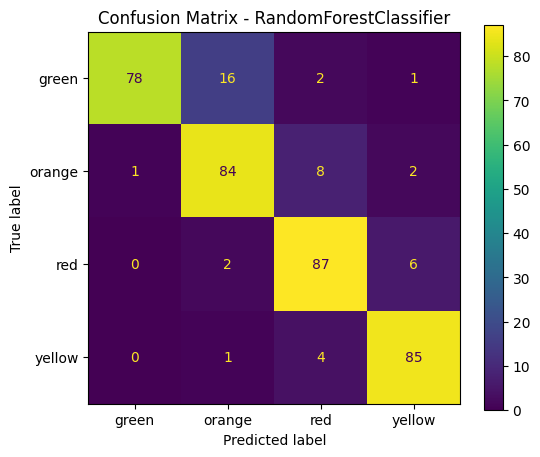


Selected features: ['magnitude', 'depth', 'cdi', 'mmi', 'sig']

--- Model evaluation: LogisticRegression

Classification Report:
              precision    recall  f1-score   support

       green       0.83      0.75      0.79        97
      orange       0.51      0.58      0.54        95
         red       0.55      0.49      0.52        95
      yellow       0.70      0.74      0.72        90

    accuracy                           0.64       377
   macro avg       0.65      0.64      0.64       377
weighted avg       0.65      0.64      0.64       377



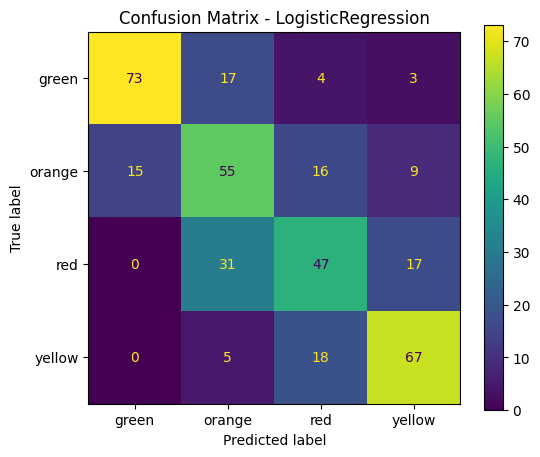


Selected features: ['magnitude', 'depth', 'cdi', 'mmi', 'sig']


In [22]:
def evaluate_model(grid_search, X_test, y_test, feature_names):
    best = grid_search.best_estimator_
    y_pred = best.predict(X_test)
    print('\n--- Model evaluation:', type(best.named_steps['clf']).__name__)
    print('\nClassification Report:')
    print(classification_report(y_test, y_pred, target_names=[str(k) for k in sorted(label_mapping.keys())]))
    
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(k) for k in sorted(label_mapping.keys())])
    fig, ax = plt.subplots(figsize=(6,5))
    disp.plot(ax=ax)
    ax.set_title(f'Confusion Matrix - {type(best.named_steps["clf"]).__name__}')
    plt.show()
    
    
    # Extract selected features
    selector = best.named_steps.get('selector')
    if selector is not None:
        # selector may be SelectKBest or SelectPercentile
        mask = selector.get_support()
        selected = [f for f, m in zip(feature_names, mask) if m]
        print('\nSelected features:', selected)
    else:
        print('\nNo selector found in pipeline.')
    

# Evaluasi RF terbaik
evaluate_model(grid_rf, X_test, y_test, FEATURES)


# Evaluasi LR terbaik
evaluate_model(grid_lr, X_test, y_test, FEATURES)

# *pengecekan model terbaik*

In [23]:
#RF
print('RF terbaik:')
print(grid_rf.best_params_)
print('Best RF cross-val score (f1_macro):', grid_rf.best_score_)

#LR
print('\nLR terbaik:')
print(grid_lr.best_params_)
print('Best LR cross-val score (f1_macro):', grid_lr.best_score_)

RF terbaik:
{'clf__class_weight': None, 'clf__max_depth': None, 'clf__n_estimators': 200, 'selector': SelectKBest(), 'selector__k': 5}
Best RF cross-val score (f1_macro): 0.8832260544334078

LR terbaik:
{'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'scaler': StandardScaler(), 'selector': SelectKBest(), 'selector__k': 5}
Best LR cross-val score (f1_macro): 0.6461791674341087


In [24]:
import pickle                                    


best_rf_model = grid_rf.best_estimator_.named_steps['clf']

with open("best_random_forest.pkl", "wb") as f:   
        pickle.dump(best_rf_model, f)                

print("✅ Model Random Forest yang terbaik berhasil disimpan ke 'best_random_forest.pkl'")

✅ Model Random Forest yang terbaik berhasil disimpan ke 'best_random_forest.pkl'
